<h1 style="align: center;font-size: 18pt;">Cineromycin B</h1>

<!--<img title="https://pubchem.ncbi.nlm.nih.gov" src="https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid=6444600&t=l" align="center" height="300" width="300">-->

<hr style="height:2.5px">

<h2 style="align: center;font-size: 12pt;"> Summary:</h2> In our previous work (DOI: <a href="https://onlinelibrary-wiley-com.libproxy.temple.edu/doi/pdf/10.1002/jcc.23738">10.1002/jcc.23738</a>), we determine solution-state conformational populations of the 14-membered macrocycle cineromycin B (O-desmethyl albocycline), using a combination of previously published sparse Nuclear Magnetic Resonance (NMR) observables and replica exchange molecular dynamic/Quantum mechanics (QM)-refined conformational ensembles. Cineromycin B is a 14-membered macrolide antibiotic that has become increasingly known for having activity against methicillin-resistant Staphylococcus Aureus (MRSA). In this example, we show how to calculate the consistency of computational modeling with experiment, and the relative importance of reference potentials and other model parameters.  We will walk through the process of setting up a `biceps` script. You are welcome to take this as a template for you and make necessary modification to get it work for you. All input files used in this tutorial are prepared from <a href="https://biceps.readthedocs.io/en/latest/examples/Tutorials/Prep_Rest_Post_Ana/preparation.html">this tutorial</a>.</h2>



**To convert this Jupyter Notebook into a script use the following command:**

```
$ jupyter nbconvert --to python cineromycinB.ipynb
```



<hr style="height:2.5px">

First, we need to import source code for BICePs classes. More information of these classes can be found [here](https://biceps.readthedocs.io/en/latest/workflow.html).

In [1]:
import numpy as np
import biceps

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


In [2]:
# What possible experimental data does biceps accept?
print(f"Possible data restraints: {biceps.toolbox.list_possible_restraints()}")
print(f"Possible input data extensions: {biceps.toolbox.list_possible_extensions()}")

Possible data restraints: ['Restraint_cs', 'Restraint_J', 'Restraint_noe', 'Restraint_pf']
Possible input data extensions: ['H', 'Ca', 'N', 'J', 'noe', 'pf']


Now we need to specify input files and output files folder.

In [3]:
####### Data and Output Directories #######
energies = np.loadtxt('cineromycin_B/cineromycinB_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case
states = len(energies)

# REQUIRED: specify directory of input data (BICePs readable format)
data = biceps.toolbox.sort_data('cineromycin_B/J_NOE')

# REQUIRED: specify outcome directory of BICePs sampling
outdir = 'results'
# Make a new directory if we have to
biceps.toolbox.mkdir(outdir)

Next, we need to specify number of steps for BICePs sampling. We recommend to run at least 1M steps for converged Monte Carlo samplings. In BICePs, we also prepare functions of [checking convergence](https://biceps.readthedocs.io/en/latest/examples/Tutorials/Convergence/convergence.html) of Monte Carlo. More information can be found [here](https://biceps.readthedocs.io/en/latest/biceps.html#convergence).

In [4]:
# REQUIRED: number of MCMC steps for each lambda
nsteps = 10000000 # 10 M steps

We need to specify what lambda values we want to use in BICePs samplings. Briefly, lambda values are similar to the parameters used in free energy perturbation (FEP) and has effect on the BICePs score. The lambda values represent how much prior information from computational modeling is included in BICePs sampling (1.0 means all, 0.0 means none). As we explained in [this work](https://pubs.acs.org/doi/10.1021/acs.jpcb.7b11871), one can consider BICePs score as the relative free energy change between different models. More lambda values will increase the samplings for [multistate Bennett acceptance ratio (MBAR)](http://www.alchemistry.org/wiki/Multistate_Bennett_Acceptance_Ratio) predictions in free energy change and populations. However more lambda values also will slow down the whole process of BICePs (as more samplings need to run), so balancing the accuracy and efficiency is important. To successfully finish a BICePs sampling, lambda values of 0.0 and 1.0 are necessary. Based on our experience, the lambda values of 0.0,0.5,1.0 are good enough for BICePs sampling.

In [5]:
# REQUIRED: specify how many lambdas to sample (more lambdas will provide higher 
# accuracy but slower the whole process, lambda=0.0 and 1.0 are necessary)
n_lambdas = 2
lambda_values = np.linspace(0.0, 1.0, n_lambdas)
print(lambda_values)

[0. 1.]


Print what experimental observables are included in BICePs sampling. This is optional and provides a chance for double check before running BICePs sampling.

In this tutorial, we used both J couplings and NOE (pairwise distances) in BICePs sampling. 

In [6]:
# OPTIONAL but RECOMMENDED: print experimental restraints included (a chance for double check)
print(f"Input data: {biceps.toolbox.list_extensions(data)}")

Input data: ['J', 'noe']


Another key parameter for BICePs set-up is the type of reference potential for each experimental observables. More information of reference potential can be found [here](https://biceps.readthedocs.io/en/latest/theory.html).

Three reference potentials are supported in BICePs: uniform ('uniform'), exponential ('exp'), Gaussian ('gau').  

As we found in previous research, exponential reference potential is useful in most cases. Some higher level task may require more in reference potential selection (e.g [force field parametrization](https://pubs.acs.org/doi/10.1021/acs.jpcb.7b11871)).

(Note: It will be helpful to print out what is the order of experimental observables included in BICePs sampling as shown above.)

In [7]:
# REQUIRED: specify reference potential to use for each experimental observable
# will be in the same order as the printed observables from (print res)
ref=['uniform','exp']

If you want, you can specify nuisance parameters (uncertainty in experiments) range but it's not required. Our default parameters range is broad enough.
"gamma" is a scaling factor converting distances to NOE intensity in experiments. It is only used when NOE restraint is ued in BICePs sampling.

In [8]:
# OPTIONAL: specify nuisance parameters for each experimnetal observable
# will be in the same order as the printed observables from (print res)
# only specify if you want to narrow down the default range  
uncern=[[0.05,20.0,1.02],[0.05,5.0,1.02]]
gamma = [0.2,5.0,1.01]  

Now we need to set up BICePs samplings and feed arguments using variables we defined above. In most cases, you don't need to modify this part as long as you defined all these parameters shown above. 

In [9]:
####### MCMC Simulations #######
for lam in lambda_values:
    print(f"lambda: {lam}")
    ensemble = biceps.Ensemble(lam, energies, verbose=False)
    ensemble.initialize_restraints(input_data=data, ref_pot=ref,
            uncern=uncern, gamma=[0.2, 5.0, 1.02])
    sampler = biceps.PosteriorSampler(ensemble.to_list())
    sampler.sample(nsteps=nsteps, print_freq=1000000, verbose=True)
    sampler.traj.process_results(outdir+'/traj_lambda%2.2f.npz'%(lam))
    outfilename = 'sampler_lambda%2.2f.pkl'%(lam)
    fout = open(os.path.join(outdir, outfilename), 'wb')
    pickle.dump(sampler, fout)
    fout.close()
    print('...Done.')

lambda: 0.0
Step		State	Para Indices		Energy		Acceptance (%)
0		33	[[151], [116, 81]]	119.297		100.00
1000000		87	[[223], [149, 102]]	6.367		71.49
2000000		23	[[251], [144, 105]]	10.597		71.61
3000000		22	[[242], [145, 96]]	8.970		71.56
4000000		21	[[219], [114, 97]]	7.765		71.65
5000000		66	[[280], [131, 97]]	11.077		71.48
6000000		47	[[252], [143, 104]]	11.953		71.31
7000000		45	[[238], [126, 99]]	7.611		71.23
8000000		45	[[250], [124, 95]]	7.041		71.21
9000000		59	[[222], [171, 95]]	14.392		71.15

Accepted 71.14281 % 


Accepted [ ...Nuisance paramters..., state] %%
Accepted [32.74304 29.88213 29.88213  8.51764] % 

...Done.
lambda: 1.0
Step		State	Para Indices		Energy		Acceptance (%)
0		0	[[150], [116, 81]]	128.034		100.00
1000000		59	[[240], [154, 96]]	7.682		64.13
2000000		39	[[258], [130, 99]]	10.780		64.23
3000000		59	[[236], [143, 93]]	6.438		64.28
4000000		90	[[237], [161, 93]]	9.077		64.29
5000000		85	[[277], [126, 96]]	9.104		64.32
6000000		59	[[302], [111, 95]]	11.312		64.

**Note that all output trajectories and images will be placed in the previously defined `outdir` as 'results_ref_normal'...**

**Also note that the user can quickly check to see if our MCMC trajectories have converged using our `biceps.convergence` module. See [this tutorial](https://biceps.readthedocs.io/en/latest/examples/Tutorials/Convergence/convergence.html) for an example and more details.**

Then, we need to run functions in [Analysis](https://biceps.readthedocs.io/en/latest/biceps.html#analysis) to get predicted populations of each conformational states and BICePs score. A figure of posterior distribution of populations and nuisance parameters will be plotted as well. 

The output files include: population information ("populations.dat"), figure of sampled parameters distribution ("BICePs.pdf"), BICePs score information ("BS.dat").

Loading results/traj_lambda0.00.npz ...
Loading results/traj_lambda1.00.npz ...
not all state sampled, these states [ 4  5  9 11 13 15 16 22 24 25 26 27 34 40 42 48 51 52 54 62 73 76 77 81
 87 95 98 99] are not sampled
Loading results/sampler_lambda0.00.pkl ...
Loading results/sampler_lambda1.00.pkl ...
lam = [0.0, 1.0]
nstates 100
Writing results/BS.dat...
...Done.
Writing results/populations.dat...
...Done.


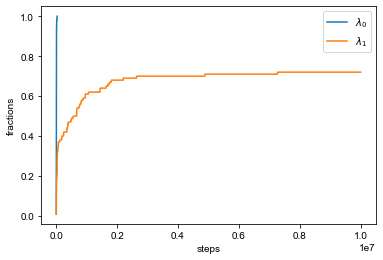

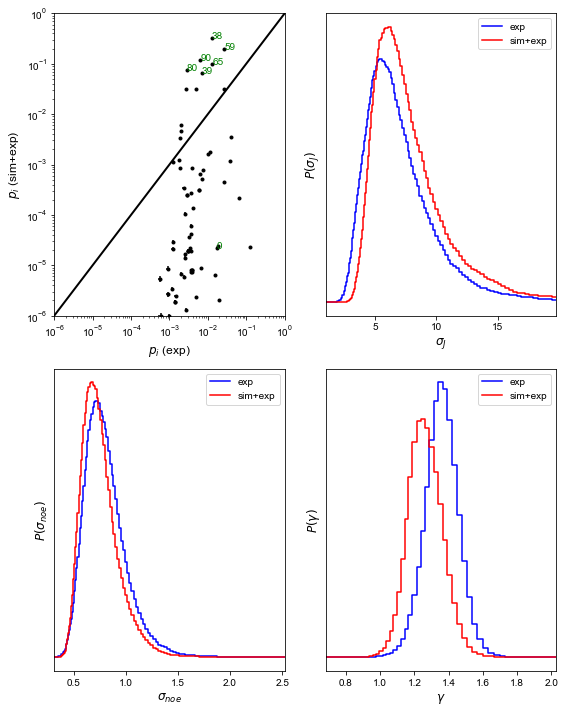

In [4]:
############ MBAR and Figures ###########
%matplotlib inline
# Let's do analysis using MBAR algorithm and plot figures
A = biceps.Analysis(states=states, resultdir=outdir,
    BSdir='BS.dat', popdir='populations.dat',
    picfile='BICePs.pdf')
A.plot(show=True)

Now, let's take a look at the output figure above ("BICePs.pdf").


The top left panel shows the population of each states in the presence (y-axis) and absense (x-axis) of computational modeling prior information. You can find some states (e.g state 38, 59) get awarded after including computational prior information. If you check [this work](https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.23738) you will see how misleading the results will be if we only use experimental restraints without computational prior information. 
The other three panels show the distribution of nuisance parameters in the presence or absence of computational modeling information. It may not be clear in this example due to the limit of finite sampling, but based on our experience, including prior information from our simulations will lower the nuisance parameters than only using experimental restraints.

Next, let's take a look at the populations file.

There are 100 rows corresponding to 100 clustered states. Four columns corresponding to populations of each state (row) for 2 lambda values (first 2 columns) and population change (last 2 columns). 

In [5]:
import pandas as pd
pops = np.loadtxt(outdir+'/populations.dat')
df = pd.DataFrame(pops)
print(df)

           0             1         2             3
0   0.017158  2.203805e-05  0.000410  5.357668e-07
1   0.003782  8.038469e-06  0.000194  4.136070e-07
2   0.007418  7.816113e-04  0.000258  2.737407e-05
3   0.000565  5.318498e-06  0.000075  7.046287e-07
4   0.000310  9.283943e-08  0.000056  1.667566e-08
..       ...           ...       ...           ...
95  0.005040  9.690027e-12  0.000224           NaN
96  0.003080  1.964245e-05  0.000175  1.117146e-06
97  0.003802  8.110902e-06  0.000194  4.162408e-07
98  0.003290  3.403677e-11  0.000181  1.164153e-10
99  0.001730  3.172908e-07  0.000131  2.414103e-08

[100 rows x 4 columns]


<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme.css", "r").read()
    return HTML(styles)
css_styling()